# Tutorial Part 14: Modeling Protein-Ligand Interactions with Atomic Convolutions
By [Nathan C. Frey](https://ncfrey.github.io/) | [Twitter](https://twitter.com/nc_frey) and [Bharath Ramsundar](https://rbharath.github.io/) | [Twitter](https://twitter.com/rbhar90)

This DeepChem tutorial introduces the [Atomic Convolutional Neural Network](https://arxiv.org/pdf/1703.10603.pdf). We'll see the structure of the `AtomicConvModel` and write a simple program to run Atomic Convolutions.

### ACNN Architecture
ACNN’s directly exploit the local three-dimensional structure of molecules to hierarchically learn more complex chemical features by optimizing both the model and featurization simultaneously in an end-to-end fashion.

The atom type convolution makes use of a neighbor-listed distance matrix to extract features encoding local chemical environments from an input representation (Cartesian atomic coordinates) that does not necessarily contain spatial locality. The following methods are used to build the ACNN architecture:

- __Distance Matrix__  
The distance matrix $R$ is constructed from the Cartesian atomic coordinates $X$. It calculates distances from the distance tensor $D$. The distance matrix construction accepts as input a $(N, 3)$ coordinate matrix $C$. This matrix is “neighbor listed” into a $(N, M)$ matrix $R$.

```python
    R = tf.reduce_sum(tf.multiply(D, D), 3)     # D: Distance Tensor
    R = tf.sqrt(R)                              # R: Distance Matrix
    return R
```

- **Atom type convolution**  
The output of the atom type convolution is constructed from the distance matrix $R$ and atomic number matrix $Z$. The matrix $R$ is fed into a (1x1) filter with stride 1 and depth of $N_{at}$ , where $N_{at}$ is the number of unique atomic numbers (atom types) present in the molecular system. The atom type convolution kernel is a step function that operates on the neighbor distance matrix $R$.

- **Radial Pooling layer**  
Radial Pooling is basically a dimensionality reduction process that down-samples the output of the atom type convolutions. The reduction process prevents overfitting by providing an abstracted form of representation through feature binning, as well as reducing the number of parameters learned.
Mathematically, radial pooling layers pool over tensor slices (receptive fields) of size (1x$M$x1) with stride 1 and a depth of $N_r$, where $N_r$ is the number of desired radial filters and $M$ is the maximum number of neighbors.

- **Atomistic fully connected network**  
Atomic Convolution layers are stacked by feeding the flattened ($N$, $N_{at}$ $\cdot$ $N_r$) output of the radial pooling layer into the atom type convolution operation. Finally, we feed the tensor row-wise (per-atom) into a fully-connected network. The
same fully connected weights and biases are used for each atom in a given molecule.

Now that we have seen the structural overview of ACNNs, we'll try to get deeper into the model and see how we can train it and what we expect as the output.

For the training, we will use the publicly available PDBbind dataset. In this example, every row reflects a protein-ligand complex and the target is the binding affinity ($K_i$) of the ligand to the protein in the complex.

## Colab

This tutorial and the rest in this sequence are designed to be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/14_Modeling_Protein_Ligand_Interactions_With_Atomic_Convolutions.ipynb)

## Setup

To run DeepChem within Colab, you'll need to run the following cell of installation commands. This will take about 5 minutes to run to completion and install your environment.

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
import conda_installer
conda_installer.install()
!/root/miniconda/bin/conda info -e

In [ ]:
!/root/miniconda/bin/conda install -c conda-forge mdtraj -y -q  # needed for AtomicConvs

In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

In [ ]:
import deepchem as dc
import os

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

from rdkit import Chem

from deepchem.molnet import load_pdbbind
from deepchem.models import AtomicConvModel
from deepchem.feat import AtomicConvFeaturizer

### Getting protein-ligand data
If you worked through [Tutorial 13](https://github.com/deepchem/deepchem/blob/master/examples/tutorials/13_Modeling_Protein_Ligand_Interactions.ipynb) on modeling protein-ligand interactions, you'll already be familiar with how to obtain a set of data from PDBbind for training our model. Since we explored molecular complexes in detail in the [previous tutorial]((https://github.com/deepchem/deepchem/blob/master/examples/tutorials/13_Modeling_Protein_Ligand_Interactions.ipynb)), this time we'll simply initialize an `AtomicConvFeaturizer` and load the PDBbind dataset directly using MolNet.

In [ ]:
f1_num_atoms = 100  # maximum number of atoms to consider in the ligand
f2_num_atoms = 1000  # maximum number of atoms to consider in the protein
max_num_neighbors = 12  # maximum number of spatial neighbors for an atom

acf = AtomicConvFeaturizer(frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      neighbor_cutoff=4)

`load_pdbbind` allows us to specify if we want to use the entire protein or only the binding pocket (`pocket=True`) for featurization. Using only the pocket saves memory and speeds up the featurization. We can also use the "core" dataset of ~200 high-quality complexes for rapidly testing our model, or the larger "refined" set of nearly 5000 complexes for more datapoints and more robust training/validation. On Colab, it takes only a minute to featurize the core PDBbind set! This is pretty incredible, and it means you can quickly experiment with different featurizations and model architectures.

In [ ]:
%%time
tasks, datasets, transformers = load_pdbbind(featurizer=acf,
                                             save_dir='.',
                                             data_dir='.',
                                             pocket=True,
                                             reload=False,
                                             set_name='core')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


CPU times: user 43.2 s, sys: 18.6 s, total: 1min 1s
Wall time: 1min 10s


In [ ]:
datasets

(<DiskDataset X.shape: (154, 9), y.shape: (154,), w.shape: (154,), ids: ['1mq6' '3pe2' '2wtv' ... '3f3c' '4gqq' '2x00'], task_names: [0]>,
 <DiskDataset X.shape: (19, 9), y.shape: (19,), w.shape: (19,), ids: ['3ivg' '4de1' '4tmn' ... '2vw5' '1w3l' '2zjw'], task_names: [0]>,
 <DiskDataset X.shape: (20, 9), y.shape: (20,), w.shape: (20,), ids: ['1kel' '2w66' '2xnb' ... '2qbp' '3lka' '1qi0'], task_names: [0]>)

In [ ]:
train, val, test = datasets

### Training the model

Now that we've got our dataset, let's go ahead and initialize an `AtomicConvModel` to train. Keep the input parameters the same as those used in `AtomicConvFeaturizer`, or else we'll get errors. `layer_sizes` controls the number of layers and the size of each dense layer in the network. We choose these hyperparameters to be the same as those used in the [original paper](https://arxiv.org/pdf/1703.10603.pdf).

In [ ]:
acm = AtomicConvModel(n_tasks=1,
                      frag1_num_atoms=f1_num_atoms,
                      frag2_num_atoms=f2_num_atoms,
                      complex_num_atoms=f1_num_atoms+f2_num_atoms,
                      max_num_neighbors=max_num_neighbors,
                      batch_size=12,
                      layer_sizes=[32, 32, 16],
                      learning_rate=0.003,
                      )

In [ ]:
losses, val_losses = [], []

In [ ]:
%%time
max_epochs = 50

for epoch in range(max_epochs):
  loss = acm.fit(train, nb_epoch=1, max_checkpoints_to_keep=1, all_losses=losses)
  metric = dc.metrics.Metric(dc.metrics.score_function.rms_score)
  val_losses.append(acm.evaluate(val, metrics=[metric])['rms_score']**2)  # L2 Loss

CPU times: user 9min 5s, sys: 1min 58s, total: 11min 4s
Wall time: 11min 54s


The loss curves are not exactly smooth, which is unsurprising because we are using 154 training and 19 validation datapoints. Increasing the dataset size may help with this, but will also require greater computational resources.

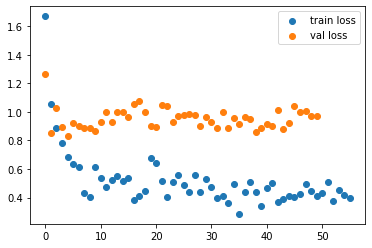

In [ ]:
f, ax = plt.subplots()
ax.scatter(range(len(losses)), losses, label='train loss')
ax.scatter(range(len(val_losses)), val_losses, label='val loss')
plt.legend(loc='upper right');

The [ACNN paper](https://arxiv.org/pdf/1703.10603.pdf) showed a Pearson $R^2$ score of 0.912 and 0.448 for a random 80/20 split of the PDBbind core train/test sets. Here, we've used an 80/10/10 training/validation/test split and achieved similar performance for the training set (0.943). We can see from the performance on the training, validation, and test sets (and from the results in the paper) that the ACNN can learn chemical interactions from small training datasets, but struggles to generalize. Still, it is pretty amazing that we can train an `AtomicConvModel` with only a few lines of code and start predicting binding affinities!  
From here, you can experiment with different hyperparameters, more challenging splits, and the "refined" set of PDBbind to see if you can reduce overfitting and come up with a more robust model.

In [ ]:
score = dc.metrics.Metric(dc.metrics.score_function.pearson_r2_score)
for tvt, ds in zip(['train', 'val', 'test'], datasets):
  print(tvt, acm.evaluate(ds, metrics=[score]))

train {'pearson_r2_score': 0.9437584772241725}
val {'pearson_r2_score': 0.16399398585969166}
test {'pearson_r2_score': 0.25027177101277903}


### Further reading
We have explored the ACNN architecture and used the PDBbind dataset to train an ACNN to predict protein-ligand binding energies. For more information, read the original paper that introduced ACNNs: Gomes, Joseph, et al. "Atomic convolutional networks for predicting protein-ligand binding affinity." [arXiv preprint arXiv:1703.10603](https://arxiv.org/abs/1703.10603) (2017). There are many other methods and papers on predicting binding affinities. Here are a few interesting ones to check out: predictions using [only ligands or proteins](https://www.frontiersin.org/articles/10.3389/fphar.2020.00069/full), [molecular docking with deep learning](https://chemrxiv.org/articles/preprint/GNINA_1_0_Molecular_Docking_with_Deep_Learning/13578140), and [AtomNet](https://arxiv.org/abs/1510.02855).

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!